### DATA 620
#### FINAL PROJECT 
### [Video Presentation](https://www.youtube.com/watch?v=IGgwXAXYtkc)
##### Group Four
- Santosh Cheruku
- Vinicio Haro
- Javern Wilson
- Saayed Alam  

In [81]:
# data processing libraries
import pandas as pd
import numpy as np
from collections import Counter

# network analysis libraries
import networkx as nx
from networkx.algorithms import bipartite as bi

# text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

# visualization librarires
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
% matplotlib inline

# settings
# pd.options.mode.chained_assignment = None

#### Introduction 
Social networks is the biggest public forum ever created by mankind and during the time of election, forums are teeming with discussions from negative to positive and everything in between. The conversations create a hub for scientists to analyze texts of large scale and find insights.

Our goal is to perform text mining on over `180,000` tweets from `May 10, 2019` to `May 20, 2019` during **2019 Australian Election**. We will implement *Sentiment Analysis* on tweets to find the overall attitude of the twitter users during the time of election. Then we will apply *Network Analysis* to find Twitter users who are best placed to influence the network and find users who can quickly connect with the wider network.

#### Dataset 
A summary of the dataset variables:  
`created_at`: Date and time of tweet creation  
`id`: Unique ID of the tweet  
`full_text`: Full tweet text  
`retweet_count`: Number of retweets  
`favorite_count`: Number of likes  
`user_id`: User ID of tweet creator  
`user_name`: Username of tweet creator  
`user_screen_name`: Screen name of tweet creator  
`user_description`: Description on tweet creator's profile  
`user_location`: Location given on tweet creator's profile  
`user_created_at`: Date the tweet creator joined Twitter 

In [3]:
# load dataset
twitter_data = pd.read_csv("auspol2019.csv", parse_dates = ['created_at', 'user_created_at'])

#### Data Exploration
We select the variables necessary for our goals and discard the remainder along with 21 rows of missing values.

In [4]:
# select varaibles
dt = twitter_data.drop(["user_created_at", "user_screen_name", "user_description", "user_location"],
                      axis = 1)

# count row with missing values
dt.isnull().sum()

created_at         0
id                 0
full_text          0
retweet_count      9
favorite_count     9
user_id            9
user_name         21
dtype: int64

In [5]:
# drop na and display data
dt = dt.dropna()
dt.head()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,7.756474e+08,Narinder Parmar
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,5.687300e+04,Peter Wells
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,9.081660e+17,The Realist
4,2019-05-20 09:13:23,1130401118666809345,"Shares were mixed in Asia, with India and Aust...",0.0,0.0,5.260074e+08,Inquirer Business


Next, we print the count of unique users, unique tweets, most retweets and most favorite tweets.

In [6]:
# some information about the dataset
print("The dataset has", len(dt.user_id.unique()), "unique users.")
print("And", len(dt.id.unique()), "unique tweets.")
print("The tweet with the most retweets had", dt['retweet_count'].max(), "retweets.")
print("The tweet with the most favorites had", dt['favorite_count'].max(), "favorites.")

The dataset has 45861 unique users.
And 183358 unique tweets.
The tweet with the most retweets had 6622.0 retweets.
The tweet with the most favorites had 15559.0 favorites.


Following Twitter user had this tweet most retweeted and favorited.

In [7]:
# tweet with most retweets and favorites
most_retweet_faves = twitter_data.loc[twitter_data["favorite_count"] == 15559.0]
print(most_retweet_faves.iloc[0][7], ">>>", most_retweet_faves.iloc[0][2])

SaraCarterDC >>> Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd


Next we visualize the number of tweets per day. As expected, the day of the election , `May 18, 2019`, had the highest number of tweets. 

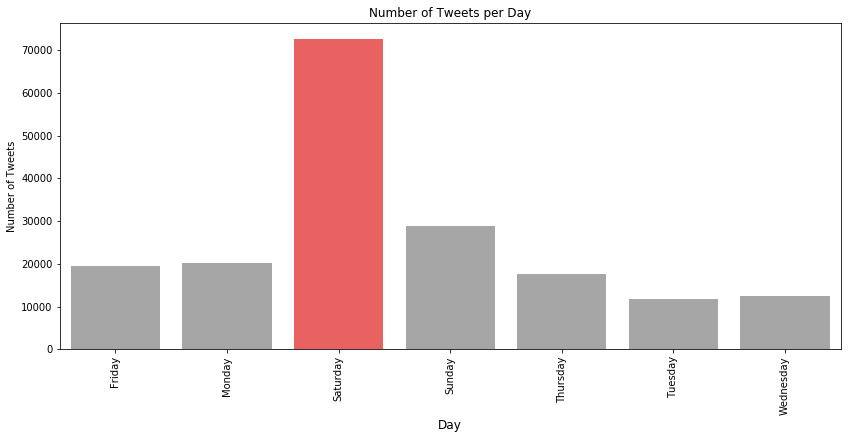

In [8]:
# number of tweets by day
dt['created_at'] =  pd.to_datetime(dt['created_at'])
cnt_srs = dt['created_at'].dt.weekday_name.value_counts()
cnt_srs = cnt_srs.sort_index()

# bar plot of tweets per day
plt.figure(figsize = (14, 6))
clrs = ['grey' if (x < max(cnt_srs.values)) else 'red' for x in cnt_srs.values]
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.7, palette = clrs)

plt.xticks(rotation = 'vertical')
plt.xlabel('Day', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize=10)
plt.title("Number of Tweets per Day")
plt.show()

#### Text Processing
Sentiment analysis, otherwise known as opinion mining is the process of determining the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within an online mention. 

In order to perform sentiment analysis on all the 180,000 tweets, we will first grab the column with the full tweets and then clean the data.

In [9]:
# get the column with the full tweets
tweets = dt[["full_text"]]

# print of a tweet
tweets.iloc[:,0][1]

'@narendramodi @smritiirani Coverage of indian election on SBS tv channel, Australia. Jai hind 🇮🇳🙏 https://t.co/90qplBEAf8'

As we can see from the example of a tweet above, our dataset has several symbols, emoticons, urls, punctuation and etc. These characters do not tell much about the dataset. Therefore, we will create a function to remove these characters. 

In [21]:
# clean text function
def tidy_tweet(text):
    stop_words = stopwords.words('english')
    lemma = nltk.WordNetLemmatizer()
    
    a = text.str.replace("#[A-Za-z0-9]+", "") # removes #hastags
    b = a.str.replace("@[A-Za-z0-9]+", "") # removes @usernames
    c = b.str.replace("https?://[A-Za-z0-9./]+", "") # removes urls
    d = c.str.replace("[^a-zA-Z]", " ") # keeps everything but alphabets
    e = d.str.lower() # lowercases the words
    f = e.apply(lambda x: x.split()) # tokenizes the tweets
    g = f.apply(lambda x: [i for i in x if i not in stop_words]) # removes stop words
    f = g.apply(lambda x: [lemma.lemmatize(i) for i in x]) # lemmatisation of words
    return f

Next, we run the function on the dataset and print the same tweet to see its performance. As we can see, usernames, puntuation, urls, emoticon and stop words are removed. And the words are lower-capitalized as well.

In [11]:
# run the function on the dataset
hf_token = tidy_tweet(tweets.full_text)

# print the same tweet after cleaning
hf_token[1]

['coverage',
 'indian',
 'election',
 'sb',
 'tv',
 'channel',
 'australia',
 'jai',
 'hind']

##### Data Exploration and Visualization of the Texts
Now that we have all the tweets cleaned, we will perform some analysis. First, we will determine the high frequency words which appeared most during the time of election. We see several words related to Australia and election appear on the list.

One distinct word in the list is `AMP` which seems not related to election at first sight to an outsider. However, AMP is a major financial company in Australia who made forecast on the economy of Australia due to the result of the election. 

A quick Google search of AMP of the election time shows economic fears drove Australia's surprise election results. [Source](https://www.wsj.com/articles/economic-fears-drove-australias-surprise-election-result-11558256778)

We also graph a cloud of words based on how often they appear. Some noticeable words are - climate and Morrison. People feared the worst for climate after Morrison won the election. [Source](https://thinkprogress.org/we-have-lost-australia-warns-climate-scientist-scott-morrison-upset-92008fabb597/)

Lastly, we visualize the high frequency words. We see the appearance of Bill `Shorten` and his `Labor` party who lost the election. 

In [12]:
# high frequency words
c = Counter()
for i in hf_token:
    c.update(i)
    
hf_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
hf_words.head(10)

,Word,Count
0,election,35402
1,australia,34189
2,vote,24221
3,labor,18521
4,amp,16082
5,party,11716
6,people,11483
7,australian,10938
8,get,9694
9,like,9505


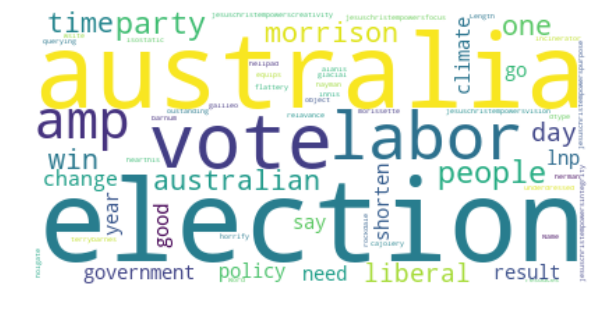

In [13]:
# word cloud of top 100 words
wordcloud = WordCloud(random_state = 21, 
                      max_words = 100, 
                      max_font_size = 110, 
                      background_color = "white").generate(str(hf_words.Word))

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

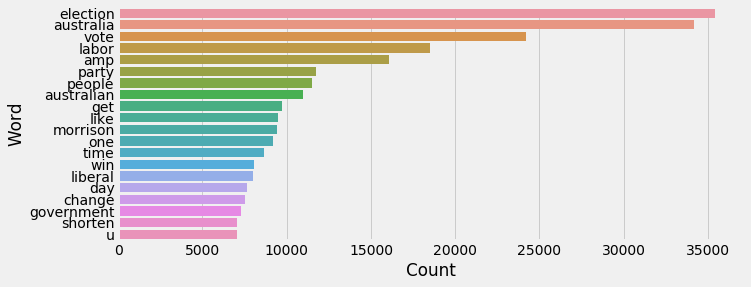

In [14]:
# visualiation of the high frequency words
style.use('fivethirtyeight')

figure, ax = plt.subplots(nrows = 1, ncols = 1)
figure.set_size_inches(10, 4)

sns.barplot(data = hf_words[:20], y = "Word", x = "Count", ax = ax)

#### Sentiment Analysis
Now that we have inspected the clean dataset, we can perform our Sentiment Analysis. `NLTK` comes with an inbuilt sentiment analyzer module `nltk.sentiment.vader` that can analyze a piece of text and classify the sentences under positive, negative and neutral polarity of sentiments. 

Next, we visualize the distribution of the sentiment and see that the overall sentiment around the election was positive. However, a large number was neutral as well. We hypothesize the overall sentiment is ambivalent. 

In [15]:
# perform SA and store the result in a new dataframe
sa = sia()
results = []
tidy_tweet = hf_token.apply(lambda x: " ".join(x))

for i in list(tidy_tweet):
    pol_score = sa.polarity_scores(i)
    pol_score['tweet'] = i
    results.append(pol_score)
    
sa_score = pd.DataFrame.from_records(results)

# create label based on positive and negative sentiment
sa_score['label'] = 0
sa_score.loc[sa_score['compound'] > 0.2, 'label'] = 1
sa_score.loc[sa_score['compound'] < -0.2, 'label'] = -1

# print first 5 rows
sa_score.head()

,compound,neg,neu,pos,tweet,label
0,0.2732,0.000,0.741,0.259,climate election shellshocked green group rema...,1
1,0.0000,0.000,1.000,0.000,coverage indian election sb tv channel austral...,0
2,-0.1531,0.169,0.704,0.127,know facebook releasing election post mortem a...,0
3,-0.2755,0.117,0.883,0.000,understand compulsory preference system vote g...,-1
4,0.6808,0.000,0.699,0.301,share mixed asia india australia leading gain ...,1


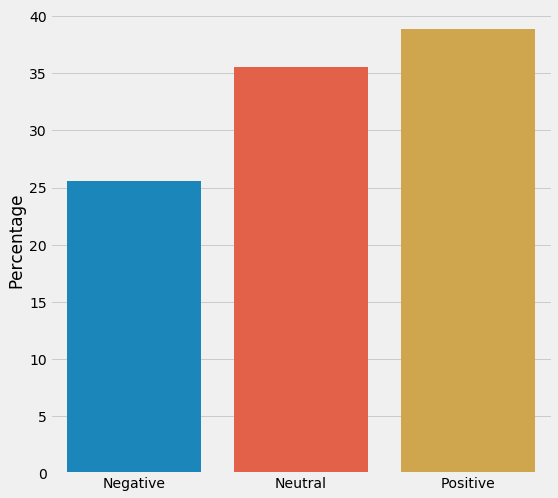

In [16]:
# distribution of the sentiment analysis
fig, ax = plt.subplots(figsize=(8, 8))

# normalize the data
counts = sa_score.label.value_counts(normalize = True) * 100

# graph the bar
sns.barplot(x = counts.index, y = counts, ax = ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

The overall sentiment does not paint an accurate picture of the opinion of the Twitter users during election. That is due to several factors - 

* The result was considered an upset as polling had placed the Coalition (winning party) consistently behind for almost three years. 
* It was the first time since 2001 that a Federal government in Australia won a third consecutive term in office. [Source](https://www.abc.net.au/news/2019-05-19/how-labor-lost-queensland-and-gifted-the-coalition-a-third-term/11122998)
* Australian Labor leader Bill Shorten have been labeled as the man who lost the unlosable election. [Source](https://blogs.spectator.co.uk/2019/05/how-climate-change-decided-australias-election/)

It seems the election had a surprise outcome. Therefore, we will separate the data into two categories, one before election results and one after the election the results. We hope to find a difference in opinion after the surprise victory by Scott Morrison.

In [17]:
# create dataset of before and after election
full_tweet = pd.concat([dt, sa_score[["tweet", "label"]]], axis = 1)
after_election = full_tweet[(full_tweet['created_at'] > '2019-05-19 00:00:01')]
before_election = full_tweet[(full_tweet['created_at'] <= '2019-05-19 00:00:01')]

The bar plot below tells us a lot more about the opinion of Twitter user during the time election than the overall sentiment. We notice several phenomenon -

* Positive: We notice a small increase in positive polarity. We believe it is due to the supporters of Scott Morrison celebrating his victory. 
* Neutral: This is where we see the most change in polarity. We hypothesize that this is due to the result being a surprise. We already saw people fear for climate after Mr. Scott won the election. We believe these tweets are of users showing concerns for the future of our climate.
* Negative: We believe the increase in negative polarity backs our hypothesize about neutral polarity. Before election, people did not care much but after the unexpected outcome, people showed their distaste and uncertainty about the future.

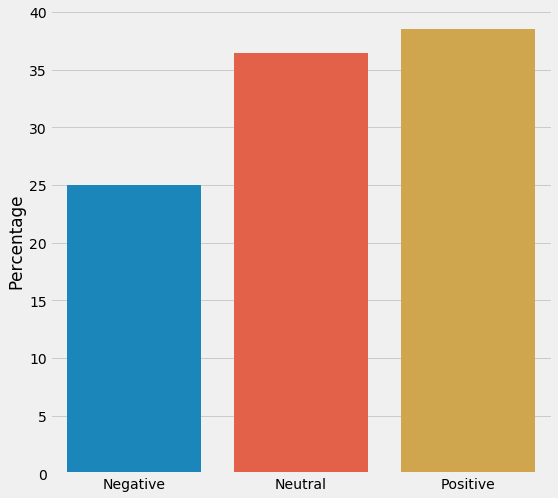

In [18]:
# distribution of the sentiment analysis of before election
fig, ax = plt.subplots(figsize=(8, 8))

# normalize the data
counts = before_election.label.value_counts(normalize = True) * 100

# graph the bar
sns.barplot(x = counts.index, y = counts, ax = ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

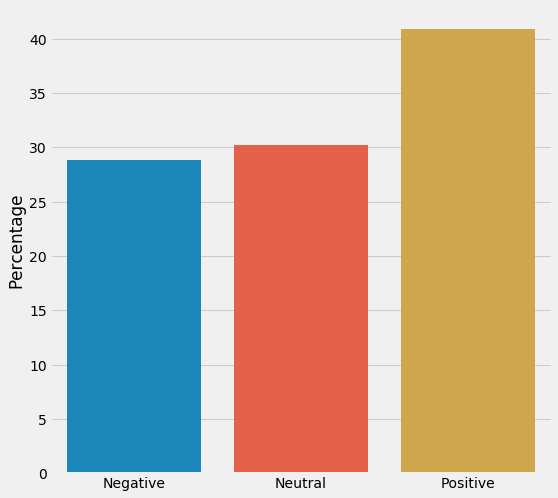

In [19]:
# distribution of the sentiment analysis of after election
fig, ax = plt.subplots(figsize=(8, 8))

# normalize the data
counts = after_election.label.value_counts(normalize = True) * 100

# graph the bar
sns.barplot(x = counts.index, y = counts, ax = ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

We can further verify our assumption by looking deeper into the words associated with their corresponding sentiment. We have noticed high frequency words does not tell much about the opinion because they are common words such as election, Australia and etc.

To better understand the opinion of Twitter users, we can filter out the words that only appear in positive tweets and filter out the words that only appear in negative tweets.

* Positive: As we assumed, the positive tweets are mostly from people who supported Scott Morrison and celebrated his victory. 
* Negative: Even though overall negative sentiment was low, we saw it increased after the election. And it is noticeable here. `Think progress` wrote the aforementioned article about climate hence their appearance on the list. We also see several words related to uncertainty of the future.

In [25]:
# unique positive words
pos_tweets = sa_score[sa_score.label == 1].tweet
pos_words = tidy_tweet(pos_tweets)

# high frequency words
c = Counter()
for i in pos_words:
    c.update(i)
    
posi_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
posi_words[np.logical_not(posi_words.Word.isin(negi_words.Word))].head(10)

,Word,Count
355,seizes,454
493,celebrates,317
775,damien,202
1618,poised,83
2678,npr,44
2843,delighted,40
2958,wilt,38
3704,appreciated,26
3756,inspirational,26
3812,azerbaijan,25


In [24]:
# unique negative words
neg_tweets = sa_score[sa_score.label == -1].tweet
neg_words = tidy_tweet(neg_tweets)

# high frequency words
c = Counter()
for i in neg_words:
    c.update(i)
    
negi_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
negi_words[np.logical_not(negi_words.Word.isin(posi_words.Word))].head(10)

,Word,Count
2976,thinkprogress,28
3199,nonexistent,26
3428,jailed,23
3482,gloom,22
3651,laborout,21
3698,forecaster,20
3885,evades,19
4000,harassing,18
4016,uproar,18
4112,reek,17


#### Social Network Analysis
Social network analysis (SNA) is the process of investigating social structures through the use of networks and graph theory. It characterizes networked structures in terms of nodes (twitter users, tweets) and the ties, edges, or links (interactions) that connect them.

As we have already noticed, the biggest change is polarity was the tweets labeled neutral and it happened after the election. And the majority of the change was towards negative opinion. Therefore, our goal is to perform network analysis on the after-election dataset to find which users spread the negative opinions.

In [26]:
# convert user id to int to create nodes
after_election['user_id'] = after_election['user_id'].apply(np.int64)
negative_tweets_ae = after_election.loc[full_tweet["label"] == -1]
negative_tweets_ae.head()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,tweet,label
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,908166034045026304,The Realist,understand compulsory preference system vote g...,-1.0
6,2019-05-20 09:12:57,1130401009782673408,It is disappointing that @tanya_plibersek has ...,0.0,0.0,51002583,Matthew Rimmer,disappointing plibersek ruled leadership chall...,-1.0
8,2019-05-20 09:12:04,1130400789694885888,'Quiet Australians' are the latest to upset el...,0.0,0.0,1740060962,Moved,quiet australian latest upset election forecas...,-1.0
17,2019-05-20 09:07:57,1130399752527306752,#财经视野 #BIZpective\nAustralia election just ove...,0.0,0.0,228310395,EG YIK FAN 吴益帆,australia election australian dollar perform h...,-1.0
18,2019-05-20 09:07:19,1130399591986155522,BBC News - 2019 Australia election: Morrison's...,0.0,0.0,1118532228886040576,markasher224,bbc news australia election morrison coalition...,-1.0


First, we create the graph of the dataset with the following nodes and edges and print the graph information - 
* `user_id`: Node 1
* `id`: Node 2
* `retweet_count` and `favourite_count`: Edge Attribute

In [27]:
# create and print graph information
G = nx.from_pandas_dataframe(negative_tweets_ae , 'user_id', 'id', edge_attr = ['retweet_count', 'favorite_count'], create_using=nx.Graph())
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 12307
Number of edges: 7642
Average degree:   1.2419


Next, we will calculate the closeness centrality. It will help us find good broadcasters. These individuals are best placed to influence the entire network most quickly. 

We found user `1559468120` was best placed to influence the entire network.

In [62]:
# closeness centrality
close = nx.closeness_centrality(G)
closeness = pd.DataFrame([close.values()], columns = close.keys()).T.reset_index()
closeness.rename(columns = {0: 'Closeness Centrality', 'index': 'Nodes'}, inplace = True)
closeness.sort_values(['Closeness Centrality'], ascending = False, inplace = True)
closeness.head()

,Nodes,Closeness Centrality
4177,1559468120,0.005038
3646,108577207,0.004226
4090,775468048908029952,0.002925
4046,413624285,0.002600
7336,1130129048972083205,0.002540


Lastly, we calculate `EigenCentrality`. By calculating the extended connections of a node, `EigenCentrality` can identify nodes with influence over the whole network, not just those directly connected to it. 

We see the appearance of the same individual on closeness centrality and eigenvector centrality. 

In [63]:
# eigenvector centrality
eigen = nx.eigenvector_centrality_numpy(G)
eigencentrality = pd.DataFrame([eigen.values()], columns = eigen.keys()).T.reset_index()
eigencentrality.rename(columns ={0: 'Eigenvector Centrality','index': 'Nodes'}, inplace = True)
eigencentrality.sort_values(['Eigenvector Centrality'], ascending = False, inplace = True)
eigencentrality.head()

,Nodes,Eigenvector Centrality
4177,1559468120,0.707107
7326,1130133506254761984,0.089803
7220,1130174899266265088,0.089803
7199,1130187044213235712,0.089803
4931,1130355052671979520,0.089803


We notice a familiar user id on both of the centrality measures above. After extracting his name from the data and a quick view of his twitter profile shows us he is very opinionated about politics. 

Below is also an excerpt from one his tweet. It demonstrates his negative attitude towards the outcome of the result and disdain towards Labor Party for losing the unlosable election.

In [79]:
# person who spread negative sentiments
influencer = after_election.loc[after_election["user_id"] == 1559468120]
print(influencer.iloc[:,6][30641], "had", influencer.retweet_count.count(), "retweets and",
     influencer.favorite_count.count(), "favorite tweets in two days after the election.")

Robert Hazeltine had 162 retweets and 162 favorite tweets in two days after the election.


In [80]:
print(influencer.iloc[:,2][32570])

What should Labor being doing now if they were a football team?  The Bradbury strategy didn't work so what wil? #auspol


#### Conclusion
For our final project, we wanted to look at the opinions surrounding the 2019 Australian Election on Twitter, one of the largest public discussion forum of our time. At first, the sentiment analysis did not tell us much about the overall opinion about the election. The election was a surprise and the overall sentiment was positive. It did not make sense therefore we dived deeper to find the changes in opinion after the election.   

We found that people were disinterested at first but after the surprise victory, a lot of users voiced their negative opinion on twitter about the possibility of a bleak future.   

We also found through our network analysis, one individual who voiced his negative opinion via several tweets about the surprising outcome and was a central figure in the wider network and influenced it the most. 

After the election, The new prime minister Scott Morrison stated "the quiet Australians ... have won a great victory". The Australian Financial Review used data from the Australian Election Study to define Quiet Australians as being "increasingly disaffected with the political system, and that Education surpassed income as the demographic characteristic most correlated with a swing to either major party". [Source](https://www.afr.com/news/politics/national/quiet-australians-are-disaffected-and-divided-20190523-p51qb4)

We believe our findings through the study of this dataset correlates with the statement made by The Australian Financial Review. 